In [1]:
 import os
import csv
import pandas as pd

# Function to traverse the subfolders and collect image paths
def collect_image_paths(root_folder):
    image_paths = []
    for folder_num, folder_name in enumerate(sorted(os.listdir(root_folder)), start=1):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Add more image extensions if needed
                    image_path = os.path.join(folder_path, filename)
                    image_paths.append((image_path, folder_num))
    return image_paths

# Function to write the image paths and labels to a CSV file
def write_to_csv(image_paths, csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Image Path', 'Label'])
        for image_path, label in image_paths:
            csv_writer.writerow([image_path, label])

# Main function
def main():
    root_folder = 'D:\SEM - 6\DP\Project\Segmented Medicinal Leaf Images'
    csv_filename = 'image_labels.csv'
    image_paths = collect_image_paths(root_folder)
    write_to_csv(image_paths, csv_filename)
    df = pd.read_csv(csv_filename)
    print(df.head(100))
    print("CSV file created successfully.")

if __name__ == "__main__":
    main()



<>:27: SyntaxWarning: invalid escape sequence '\S'
<>:27: SyntaxWarning: invalid escape sequence '\S'
C:\Users\abhin\AppData\Local\Temp\ipykernel_33452\2510584115.py:27: SyntaxWarning: invalid escape sequence '\S'
  root_folder = 'D:\SEM - 6\DP\Project\Segmented Medicinal Leaf Images'


                                           Image Path  Label
0   D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      1
1   D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      1
2   D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      1
3   D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      1
4   D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      1
..                                                ...    ...
95  D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      2
96  D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      2
97  D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      2
98  D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      2
99  D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      2

[100 rows x 2 columns]
CSV file created successfully.


In [2]:
import pandas as pd
csv_file = r"D:\SEM - 6\DP\Project\image_labels.csv"  # Assuming your CSV file contains two columns: 'image_path' and 'label'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Assuming the CSV has columns named 'img_paths' and 'label'
# Group by 'label' and count the occurrences
label_counts = df.groupby('Label').size()

# Print the count of images for each label
print(label_counts)


Label
1      50
2     122
3      56
4      60
5     103
6      34
7      74
8      57
9      50
10     63
11     43
12     71
13     62
14     97
15     77
16     56
17     60
18     62
19     40
20     52
21     48
22     48
23     61
24     65
25     79
26     58
27     39
28     56
29     56
30     36
dtype: int64


In [4]:
import pandas as pd
# from vit_pytorch import ViT
import torch
from torchvision import datasets, transforms, models
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from torch.utils.data import random_split


from torch.utils.data import random_split, Dataset, DataLoader
import pandas as pd




In [5]:


# Load CSV file containing image paths and labels
csv_file = r"D:\SEM - 6\DP\Project\image_labels.csv" # Replace with your CSV file path
df = pd.read_csv(csv_file)

# Define transforms to apply to the images
transform = transforms.Compose([
    transforms.Resize((144,144)),  # Resize images to 256x256
    transforms.ToTensor(),           # Convert images to tensors
])



# Function to load images and labels
def load_images_and_labels(csv_file, transform):
    images = []
    labels = []
    for index, row in df.iterrows():
        image_path = row['Image Path']
        label = row['Label']-1
        # Load image
        image = Image.open(image_path).convert('RGB')
        # Apply transforms
        image = transform(image)
        images.append(image)
        labels.append(label)
    return torch.stack(images), torch.tensor(labels)

# Load images and labels
images, labels = load_images_and_labels(csv_file, transform)

# Assuming you have defined your train and validation datasets
# Split the dataset into train and validation sets
dataset = TensorDataset(images, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders for train and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)


# Print the shape of the images tensor
print("Image size after transformations:", images.shape[2:])  # Excluding batch size and channels

Image size after transformations: torch.Size([144, 144])


Google-net

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np

# Assuming you have defined train_dataloader and val_dataloader for your data

# Initialize the GoogleNet (Inception) model
model = models.googlenet(pretrained=True)

# Modify the classification head for 8 classes (assuming 8 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 30)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 50
best_loss = float('inf')  # Initialize with a high value
patience = 5  # Number of epochs to wait for improvement

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_running_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
    
    val_loss = val_running_loss / len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Print epoch stats
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Accuracy: {100 * train_accuracy}%, Val Accuracy: {100 * val_accuracy}%")

    # Early stopping logic based on training loss
    if train_loss < best_loss:
        best_loss = train_loss
        patience = 5  # Reset patience counter
    else:
        patience -= 1
        if patience == 0:
            print(f"Early stopping triggered after {epoch + 1} epochs due to no improvement in training loss")
            break

# Save the trained model
torch.save(model.state_dict(), 'resnet_50_classes.pth')

c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 2.2209491032995383, Val Loss: 1.5108846144183823, Train Accuracy: 35.6267029972752%, Val Accuracy: 50.40871934604905%
Epoch 2/50, Train Loss: 1.3665745360852912, Val Loss: 0.81663174979495, Train Accuracy: 57.01634877384196%, Val Accuracy: 71.38964577656675%
Epoch 3/50, Train Loss: 1.0508907411135835, Val Loss: 0.9476796826246477, Train Accuracy: 67.23433242506812%, Val Accuracy: 71.66212534059946%
Epoch 4/50, Train Loss: 0.9103766122340587, Val Loss: 0.7741566493236662, Train Accuracy: 71.38964577656675%, Val Accuracy: 74.65940054495913%
Epoch 5/50, Train Loss: 0.7181397159089022, Val Loss: 1.0864815523243083, Train Accuracy: 77.72479564032697%, Val Accuracy: 70.02724795640327%
Epoch 6/50, Train Loss: 0.6037558803832215, Val Loss: 0.6337674290559295, Train Accuracy: 80.72207084468664%, Val Accuracy: 81.74386920980926%
Epoch 7/50, Train Loss: 0.5222231160737676, Val Loss: 0.3356647131111696, Train Accuracy: 83.5149863760218%, Val Accuracy: 89.64577656675749%
Epo

In [8]:
import pickle
# Save the final model
with open('final_model.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f)

Evaluation Metrics

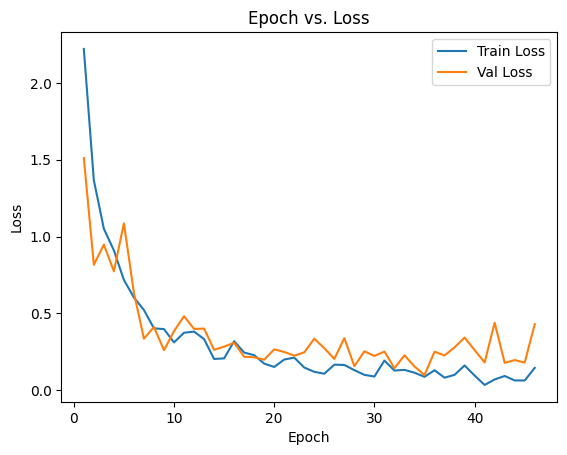

In [9]:
# Plot epoch vs. loss
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs. Loss')
plt.legend()
plt.show()

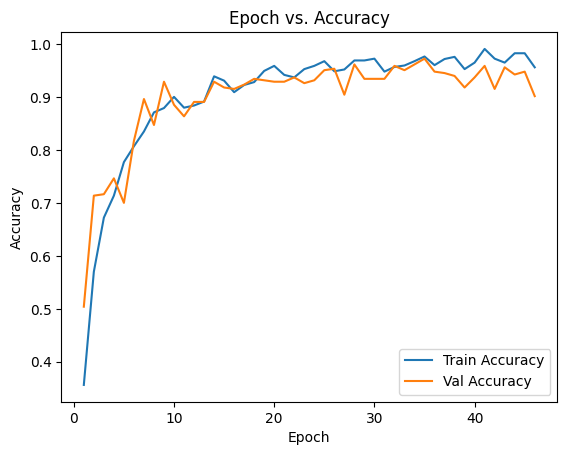

In [10]:
# Plot epoch vs. accuracy
plt.figure()
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs. Accuracy')
plt.legend()
plt.show()

In [19]:
import torch
from sklearn.metrics import precision_score, f1_score, recall_score
import numpy as np

# Assuming model, device, and val_dataloader are defined and the model is already trained and loaded

def calculate_metrics(model, dataloader, num_classes):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    predicted_labels = np.argmax(all_outputs, axis=1)

    precision_per_class = precision_score(all_labels, predicted_labels, average=None, labels=np.arange(num_classes)).tolist()
    recall_per_class = recall_score(all_labels, predicted_labels, average=None, labels=np.arange(num_classes)).tolist()
    f1_per_class = f1_score(all_labels, predicted_labels, average=None, labels=np.arange(num_classes)).tolist()

    overall_precision = precision_score(all_labels, predicted_labels, average='weighted')
    overall_recall = recall_score(all_labels, predicted_labels, average='weighted')
    overall_f1 = f1_score(all_labels, predicted_labels, average='weighted')

    accuracy = (predicted_labels == all_labels).sum() / len(all_labels)

    return {
        "precision_per_class": precision_per_class,
        "recall_per_class": recall_per_class,
        "f1_per_class": f1_per_class,
        "overall_precision": overall_precision,
        "overall_recall": overall_recall,
        "overall_f1": overall_f1,
        "accuracy": accuracy
    }

# Calculate metrics for validation data
metrics = calculate_metrics(model, val_dataloader, num_classes=30)

# Print metrics in list format
print("Validation Precision per Class:", metrics["precision_per_class"])
print("Validation Recall per Class:", metrics["recall_per_class"])
print("Validation F1 Score per Class:", metrics["f1_per_class"])

print(f"Validation Overall Precision: {metrics['overall_precision']:.4f}")
print(f"Validation Overall Recall: {metrics['overall_recall']:.4f}")
print(f"Validation Overall F1 Score: {metrics['overall_f1']:.4f}")
print(f"Validation Accuracy: {metrics['accuracy']:.4f}")


Validation Precision per Class: [1.0, 1.0, 0.9166666666666666, 1.0, 0.9285714285714286, 1.0, 0.7272727272727273, 0.9, 0.7142857142857143, 1.0, 0.7857142857142857, 0.9333333333333333, 1.0, 1.0, 1.0, 1.0, 0.5625, 0.9230769230769231, 1.0, 0.8333333333333334, 0.7272727272727273, 0.8888888888888888, 0.8461538461538461, 1.0, 0.8928571428571429, 1.0, 0.8571428571428571, 0.7857142857142857, 0.9, 1.0]
Validation Recall per Class: [0.36363636363636365, 0.8846153846153846, 1.0, 1.0, 0.9285714285714286, 0.875, 1.0, 0.9, 0.5, 1.0, 1.0, 0.7777777777777778, 1.0, 0.9411764705882353, 0.8823529411764706, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 0.8823529411764706, 1.0, 1.0, 0.6, 1.0]
Validation F1 Score per Class: [0.5333333333333333, 0.9387755102040817, 0.9565217391304348, 1.0, 0.9285714285714286, 0.9333333333333333, 0.8421052631578947, 0.9, 0.5882352941176471, 1.0, 0.88, 0.8484848484848485, 1.0, 0.9696969696969697, 0.9375, 1.0, 0.72, 0.96, 1.0, 0.8333333333333334

In [16]:
def calculate_accuracy_per_class(model, dataloader, num_classes):
    model.eval()
    class_correct = torch.zeros(num_classes)
    class_total = torch.zeros(num_classes)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = predicted == labels
            for i in range(num_classes):
                class_correct[i] += (correct * (labels == i)).sum().item()
                class_total[i] += (labels == i).sum().item()

    accuracy_per_class = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return accuracy_per_class

# Calculate accuracy for validation data
val_accuracy_per_class = calculate_accuracy_per_class(model, val_dataloader, num_classes=30)
for i, acc in enumerate(val_accuracy_per_class):
    print(f"Validation Accuracy for class {i+1}: {acc:.4f}")




Validation Accuracy for class 1: 0.3636
Validation Accuracy for class 2: 0.8846
Validation Accuracy for class 3: 1.0000
Validation Accuracy for class 4: 1.0000
Validation Accuracy for class 5: 0.9286
Validation Accuracy for class 6: 0.8750
Validation Accuracy for class 7: 1.0000
Validation Accuracy for class 8: 0.9000
Validation Accuracy for class 9: 0.5000
Validation Accuracy for class 10: 1.0000
Validation Accuracy for class 11: 1.0000
Validation Accuracy for class 12: 0.7778
Validation Accuracy for class 13: 1.0000
Validation Accuracy for class 14: 0.9412
Validation Accuracy for class 15: 0.8824
Validation Accuracy for class 16: 1.0000
Validation Accuracy for class 17: 1.0000
Validation Accuracy for class 18: 1.0000
Validation Accuracy for class 19: 1.0000
Validation Accuracy for class 20: 0.8333
Validation Accuracy for class 21: 1.0000
Validation Accuracy for class 22: 0.8889
Validation Accuracy for class 23: 1.0000
Validation Accuracy for class 24: 1.0000
Validation Accuracy for c

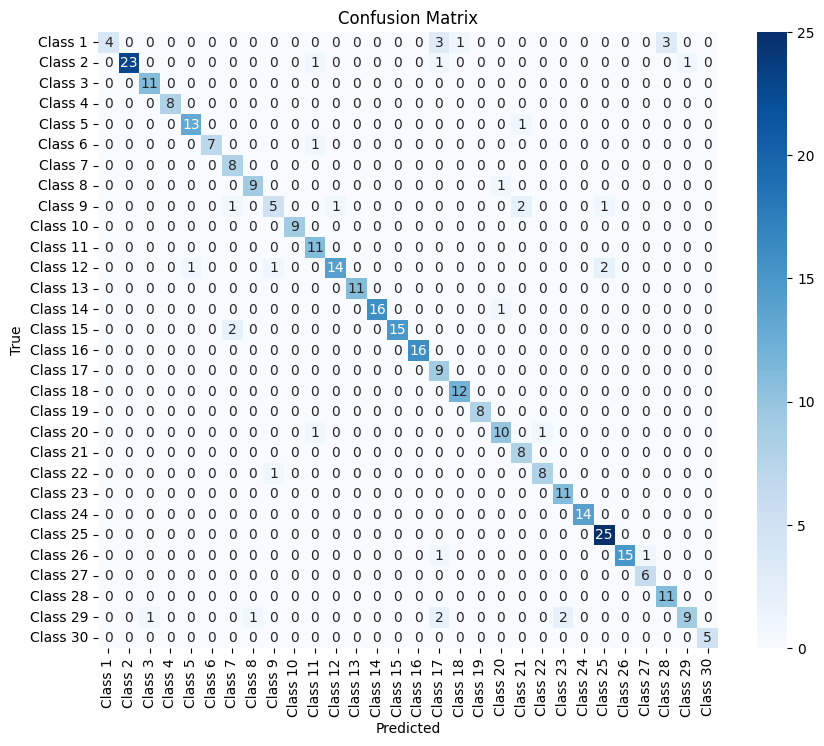

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


def collect_predictions_and_labels(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions)

# Collect predictions and true labels for the validation set
true_labels, predictions = collect_predictions_and_labels(model, val_dataloader)
cm = confusion_matrix(true_labels, predictions, labels=np.arange(30))

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Define your class names
class_names = [f'Class {i+1}' for i in range(30)]

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)


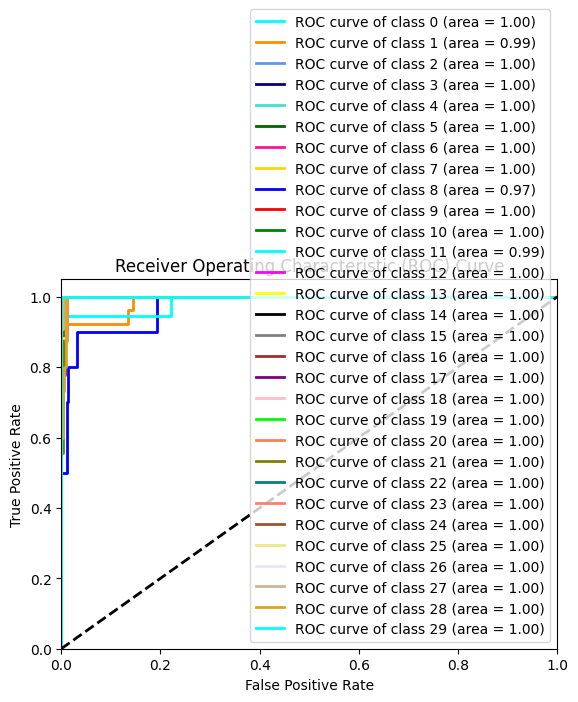

In [14]:
 # Calculate ROC curve and ROC area for each class
all_labels = np.concatenate(all_labels)
all_outputs = np.concatenate(all_outputs)
n_classes = 30
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_outputs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'turquoise', 'darkgreen', 'deeppink', 'gold', 'blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'grey', 'brown', 'purple', 'pink', 'lime', 'coral', 'olive', 'teal', 'salmon', 'sienna', 'khaki', 'lavender', 'tan', 'goldenrod'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
 








In [15]:
from torchvision import transforms
from PIL import Image


# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.eval()
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((144,144)),  # Resize to the size GoogleNet expects
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
   
])

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image


def predict(image_path, model, device):
    # Preprocess the image
    image = preprocess_image(image_path)
    image = image.to(device)
    
    # Make predictions
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
    
    return predicted.item()

# Example usage
image_path = r"D:\SEM - 6\DP\Project\Segmented Medicinal Leaf Images\Plectranthus Amboinicus (Mexican Mint)\PA-S-022.jpg"
predicted_class = predict(image_path, model, device)
print(f'The predicted class is: {predicted_class}')


The predicted class is: 21
